# Setup

In [26]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime
import pandas as pd

from pandas import DataFrame,Series,read_table

General info

In [27]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig S4/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsPath = './Fig 09/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig'

In [28]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

In [29]:
# THIS NOTEBOOK ONLY: define more video stages
stagesVideo = ['m','q','d','l','g','s','u'] # moving wake, quiet wake, drowsy, L unihem, R unihem, sleep, unclear

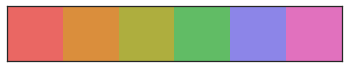

In [30]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

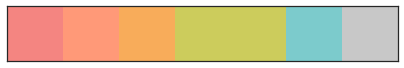

In [31]:
colors_video = sns.color_palette(np.array([[244,133,129],
                                           [255,153,120],
                                            [248,172,90],
                                            [204,204,92],
                                            [204,204,92],
                                            [124, 203, 204],
                                            [200, 200, 200]])
                                            /(255))

sns.palplot(colors_video)

Plot-specific info

In [32]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of video scoring colors
legendMarkersVideo = []
for stage in range(len(stagesVideo)):
    legendMarkersVideo.append(plt.Line2D([0],[0], color=colors_video[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [33]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

### Read in: Video scores

In [34]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    
    # if any epochs missing, mark as unclear
    date_index = pd.date_range(data.index.values[0], end=data.index.values[-1], freq='3s')
    data_reindexed = data.reindex(date_index.astype('str'))
    data_reindexed['Video Label'].fillna('u', inplace=True)
    
    # interpolate Time-related columns
    time_columns = ['Time (s)', 'Time (h)', 'Zeitgeber time (s)', 'Zeitgeber time (h)', 
                    'Zeitgeber time (ep)', 'Epoch #']
    data_interpolated = data_reindexed.copy()
    data_interpolated[time_columns] = data_reindexed[time_columns].interpolate()
    
    AllScores[bird_name] = data_interpolated

In [35]:
# LL
AllScores_LL = {}
for b in [1,2,3]:
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + 'LL.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores_LL[bird_name] = data

## Convert video score labels to numbers: 

In [36]:
# LD #
for b_num in range(nBirds):

    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]

    Label_num = -1 * np.ones_like(Scores['Video Label'])
    for st in range(len(stagesVideo)):
        stage_inds = [x for x in range(len(Scores['Label'])) if stagesVideo[st] in Scores['Video Label'].iloc[x]]
        Label_num[stage_inds] = st

    # Preening/singing labels
    stage_inds = [x for x in range(len(Scores['Video Label']))
                  if ('p' in Scores['Video Label'].iloc[x])|('si' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 0

    # Save to dataframe
    AllScores[b_name]['Video Label (#)'] = Label_num

In [37]:
# LL #
for b_num in [1,2,3]:

    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores_LL[b_name]
    # replace nan's with empty string
    Scores.fillna('', inplace=True)

    Label_num = -1 * np.ones_like(Scores['Video Label'])
    for st in range(len(stagesVideo)):
        stage_inds = [x for x in range(len(Scores['Epoch #'])) if stagesVideo[st] in Scores['Video Label'].iloc[x]]
        Label_num[stage_inds] = st

    # Preening/singing labels
    stage_inds = [x for x in range(len(Scores['Video Label']))
                  if ('p' in Scores['Video Label'].iloc[x])|('si' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 0

    # Unihem labels
    stage_inds = [x for x in range(len(Scores['Video Label'])) if ('g' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 4

    # Save to dataframe
    AllScores_LL[b_name]['Video Label (#)'] = Label_num

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [38]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## define PlotFig

In [39]:
def PlotFig(b_name, all_scores, plot_xlabels=True, plot_lightsonoff=True, full_stagelabels=False,
           sr=sr, colors=colors, stages=stages, xlim_min=0, shade_nighttime=True):
    '''Plot Figure: hypnogram
    b = bird name
    all_scores = dictionary containing video scores for each bird
    plot_xlabels = whether to plot the time & label at the bottom
    plot_lightsonoff = whether to plot the text labeling the lights on & off lines
    
    sr = sampling rate
    colors = list of colors to use for plotting sleep stages
    stages = list of sleep/wake stages
    shade_nighttime = whether to plot light gray box during lights off
    
    '''
    Scores = all_scores[b_name].copy()
    b = int(b_name[5]) - 1
    
    # pull out only scores within 24 hr after start of recording
    Scores = Scores[Scores['Time (h)']<=24]
                           
    xlim_max = xlim_min + 24
    if lightsOffZeit_hr[b_num]<xlim_min:
        lights_off = lightsOffZeit_hr[b_num] + 24
    else:
        lights_off = lightsOffZeit_hr[b_num]    
    
    # for Zeitgeber times falling before the desired Xmin, wrap around to next day by adding 24hrs
    too_early_inds = np.where(Scores['Zeitgeber time (h)'] < xlim_min)
    new_Zeit_hrs = Scores['Zeitgeber time (h)'].iloc[too_early_inds] + 24
    Scores['Zeitgeber time (h)'].iloc[too_early_inds] = new_Zeit_hrs.values
        
    # for each stage, make a vlines plot
    for st in range(len(stagesVideo)):
        stage_scores = Scores[Scores['Video Label (#)']==st]
        plt.vlines(stage_scores['Zeitgeber time (h)'], -st, -st - 1, 
               color=colors[st], alpha=0.1)
   
    # vertical lines at lights on and off

    if shade_nighttime:
        plt.axvline(0, alpha=0.4, color='k', lw=3)
        plt.axvline(lights_off, alpha=0.4, color='k', lw=3)
        plt.axvspan(lights_off, 24, alpha=0.1, color='k')
        
    if plot_lightsonoff:
        plt.text(-.75, 0.3, 'lights on', alpha=0.7, fontsize=12)
        plt.text(lights_off - .75, 0.3, 'lights off', alpha=0.7, fontsize=12)

    # labels of each stage
    if full_stagelabels:
        stage_labels = ['Moving','Quiet wake','Drowsy','Left Unihem', 'Right Unihem','Sleep', 'Unclear']
    else:
        stage_labels = ['M','Q','D','L','R','S','U']
        
    plt.yticks(-0.5 - np.arange(len(stages)), stage_labels)
    ax = plt.gca()
    #ax.yaxis.tick_right()     # labels on right side of plot
    for ytick, color in zip(ax.get_yticklabels(), colors):   # text color
        ytick.set_color(color)
        
    # axis labels    
    plt.ylabel(b_name, fontsize=14)
    if plot_xlabels:
        plt.xlabel('Zeitgeber hour', fontsize=14)
        ticks = ax.get_xticks()
        plt.xticks(np.arange(xlim_min, np.max(ticks), 2))
    else:
        plt.xticks([])

    # limits
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(-len(stages), 0)



## define TSTstats

In [40]:
def TSTstats(birdToRun):

#### Baseline LD 
    print('', birdToRun, 'LD')

    scores = AllScores[birdToRun]
    
    # calc number of epochs, excluding Unclear
    recording_len_ep = len(scores) - len(scores[scores['Video Label']=='u'])
    
    ## TST as % of recording time

    TST_ep = len(scores[(scores['Video Label']=='s')])

    print('TST as % of recording time: \t \t', TST_ep / recording_len_ep)

    ## TST, including epochs marked "unclear"

    TST_w_unclear_ep = len(scores[(scores['Video Label']=='s')|(scores['Video Label']=='u')])

    print('TST including Unclear epochs as sleep: \t', TST_w_unclear_ep / len(scores))

    ## TST based on PSG

    TST_ep_PSG = len(scores[(scores['Label']=='s')|(scores['Label']=='i')|(scores['Label']=='r')])

    print('TST based on PSG: \t \t \t', TST_ep / len(scores))
    
#### Constant light

    print('\n', birdToRun, 'LL')
    scores = AllScores_LL[birdToRun]
    
    # calc number of epochs, excluding Unclear
    recording_len_ep = len(scores) - len(scores[scores['Video Label']=='u'])

    ## TST as % of recording time

    TST_ep = len(scores[scores['Video Label']=='s'])

    print('TST as % of recording time: \t \t', TST_ep / recording_len_ep)

    ## TST, including epochs marked "unclear"

    TST_w_unclear_ep = len(scores[(scores['Video Label']=='s')|(scores['Video Label']=='u')])

    print('TST including Unclear epochs as sleep: \t', TST_w_unclear_ep / len(scores))

# FIGURE 09a, S4: Plot LD vs LL hypnograms

## Bird 2

In [41]:
birdToRun = 'Bird 2'
b = int(birdToRun[5]) - 1
birdToRunID = b

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


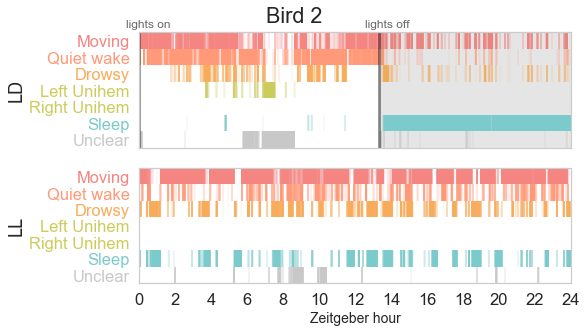

In [42]:
plt.figure(figsize=(8.5, 12*(2/5)))

axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline
    plt.subplot(2,1,1)
    PlotFig(birdToRun, AllScores, plot_xlabels=False, full_stagelabels=True, 
            colors=colors_video, stages=stagesVideo)
    plt.ylabel('LD', fontsize=18)
    
    plt.subplot(2,1,2)
    PlotFig(birdToRun, AllScores_LL, plot_lightsonoff=False, full_stagelabels=True, 
            shade_nighttime=False, colors=colors_video, stages=stagesVideo)
    plt.ylabel('LL', fontsize=18)

    plt.suptitle(birdToRun)
    plt.tight_layout()
    
if savePlots:
    name = saveAsPath + saveAsName + '9a_video_hypnograms_LL_vs_LD_' + birdToRun
    plt.savefig(name + '.tiff', dpi=300)

In [43]:
TSTstats(birdToRun)

 Bird 2 LD
TST as % of recording time: 	 	 0.3971802314622837
TST including Unclear epochs as sleep: 	 0.4435590507342195
TST based on PSG: 	 	 	 0.3666225902985594

 Bird 2 LL
TST as % of recording time: 	 	 0.14937611408199644
TST including Unclear epochs as sleep: 	 0.17118243712658052


## Bird 3

In [44]:
birdToRun = 'Bird 3'
b = int(birdToRun[5]) - 1
birdToRunID = b

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


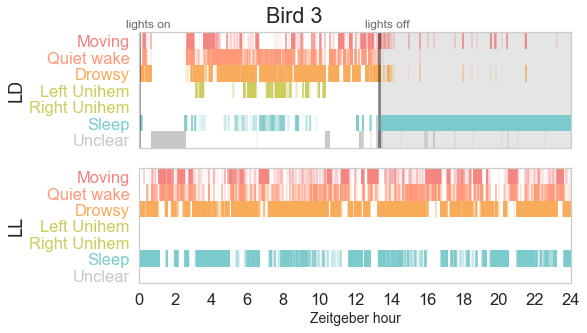

In [45]:
plt.figure(figsize=(8.5, 12*(2/5)))

axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline
    plt.subplot(2,1,1)
    PlotFig(birdToRun, AllScores, plot_xlabels=False, full_stagelabels=True, 
            colors=colors_video, stages=stagesVideo)
    plt.ylabel('LD', fontsize=18)
    
    plt.subplot(2,1,2)
    PlotFig(birdToRun, AllScores_LL, plot_lightsonoff=False, full_stagelabels=True, 
            shade_nighttime=False, colors=colors_video, stages=stagesVideo)
    plt.ylabel('LL', fontsize=18)

    plt.suptitle(birdToRun)
    plt.tight_layout()
    
if savePlots:
    name = './Fig S4/' + saveAsName + 'S4b_video_hypnograms_LL_vs_LD_' + birdToRun
    plt.savefig(name + '.tiff', dpi=300)

In [46]:
TSTstats(birdToRun)

 Bird 3 LD
TST as % of recording time: 	 	 0.49246611645339594
TST including Unclear epochs as sleep: 	 0.5410004450987776
TST based on PSG: 	 	 	 0.4453726846303968

 Bird 3 LL
TST as % of recording time: 	 	 0.25935092550632693
TST including Unclear epochs as sleep: 	 0.25935092550632693


## Bird 4

In [47]:
birdToRun = 'Bird 4'
b = int(birdToRun[5]) - 1
birdToRunID = b

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


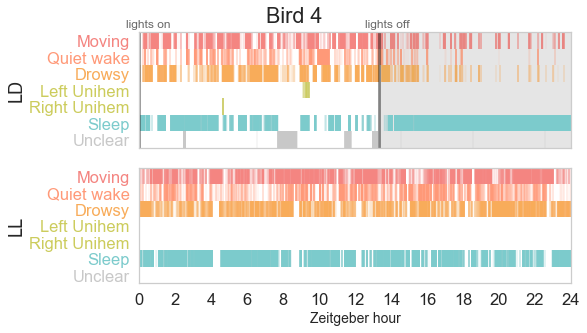

In [48]:
plt.figure(figsize=(8.5, 12*(2/5)))

axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline
    plt.subplot(2,1,1)
    PlotFig(birdToRun, AllScores, plot_xlabels=False, full_stagelabels=True, 
            colors=colors_video, stages=stagesVideo)
    plt.ylabel('LD', fontsize=18)
    
    plt.subplot(2,1,2)
    PlotFig(birdToRun, AllScores_LL, plot_lightsonoff=False, full_stagelabels=True, 
            shade_nighttime=False, colors=colors_video, stages=stagesVideo)
    plt.ylabel('LL', fontsize=18)

    plt.suptitle(birdToRun)
    plt.tight_layout()
    
if savePlots:
    name = './Fig S4/' + saveAsName + 'S4c_video_hypnograms_LL_vs_LD_' + birdToRun
    plt.savefig(name + '.tiff', dpi=300)

In [49]:
TSTstats(birdToRun)

 Bird 4 LD
TST as % of recording time: 	 	 0.5588883987648875
TST including Unclear epochs as sleep: 	 0.5833043961386207
TST based on PSG: 	 	 	 0.5279533300923676

 Bird 4 LL
TST as % of recording time: 	 	 0.38966105827846864
TST including Unclear epochs as sleep: 	 0.38966105827846864
